# CSCA 5632 — Final Project (Unsupervised Learning)
## Title: Customer Segmentation - Unsupervised Learning on Retail Data

## About the Final Project
For the final project, you will identify an Unsupervised Learning problem to perform EDA and model analysis.  

## Instructions: Step 1"Gather data, determine the method of data collection and provenance of the data."  

### Data Source, Data Collection, and Provenance
- A known data source is chosen:  
UCI Machine Learning Repository — Online Retail dataset (2010–2011 transactions from a UK-based retailer).   
URL for download: http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx  
- Fields:  
InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country  
- Provenance:  
Public academic dataset curated for research and teaching.   
- License:  
Please see the UCI page (https://archive.ics.uci.edu/dataset/352/online+retail).

## Instructions: Step 2
"Identify an Unsupervised Learning Problem."

### Unsupervised Learning - Problem Statement:
E-commerce teams often need to understand customer purchasing behavior to improve marketing.  
This can be done with customer segmentation.  

### Notebook

In [9]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [10]:
# Data Load
DATA_PATH = "http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(DATA_PATH, engine="openpyxl")

## Instructions: Step 3
"Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data."

#### Plan
We begin with basic inspection, data cleaning, and showing the data distribution.  
We will also create fields used in Recency, Frequency, and Monetary analysis.

#### Basic Inspection
- Show dataset, data type and missing values per column
- Show unique customers and countries
- Show basic statistics

In [14]:
# Basic info
print("Loaded dataset shape:", df.shape)
print("\n", df.head())
print("\n", df.dtypes)

print("\n Missing values per column:")
print(df.isna().sum())

# Unique customers and countries
num_customers = df['CustomerID'].nunique(dropna=True)
num_countries = df['Country'].nunique()
print(f"\n Unique customers: {num_customers}, Unique countries: {num_countries}")

# Basic statistics
print ()
display(df.describe(include='all').T)

Loaded dataset shape: (541909, 8)

   InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

 InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
U

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
InvoiceNo,541909.0,25900.0,573585.0,1114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909.0,NaN,NaN,NaN,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158
InvoiceDate,541909,NaN,NaN,NaN,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
UnitPrice,541909.0,NaN,NaN,NaN,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853
CustomerID,406829.0,NaN,NaN,NaN,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Data Cleaning
- The monetary value of each transaction is missing: create a total price.
- Remove rows with missing CustomerID for customer-level analysis.
- Remove rows which have other than positive Quantity or positive UnitPrice.
- Remove rows with missing dates.
- Quick check of the cleaned dataset.

In [16]:
# Data Cleaning 

# Create total price 
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Filter 
df_clean = df.dropna(subset=['CustomerID', 'InvoiceDate']).copy()

# Keep positive quantities and prices 
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Check
print("Cleaned dataset shape:", df_clean.shape)
display(df_clean.head())
print("\n Missing values per column:")
print(df_clean.isna().sum())

Cleaned dataset shape: (397884, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34



 Missing values per column:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64


#### Show Data Distribution

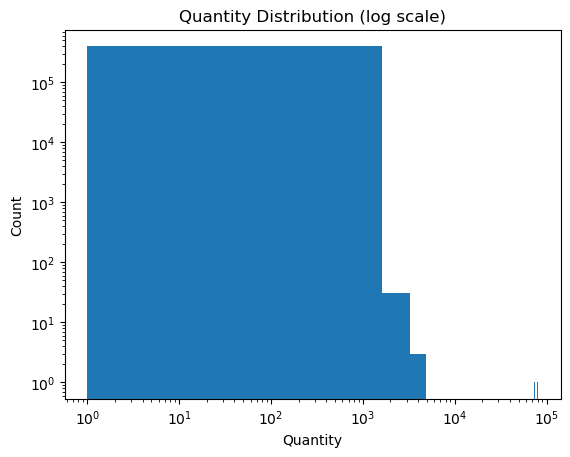

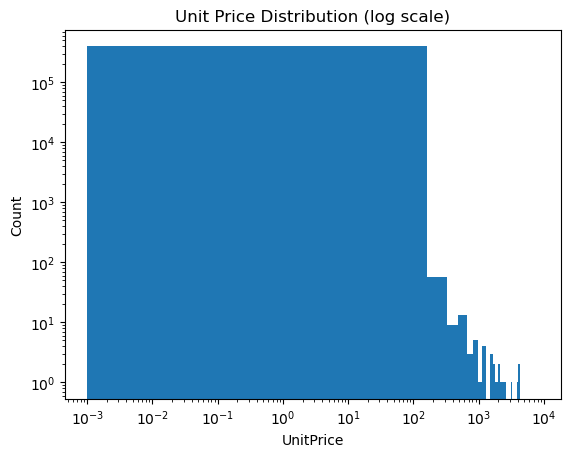

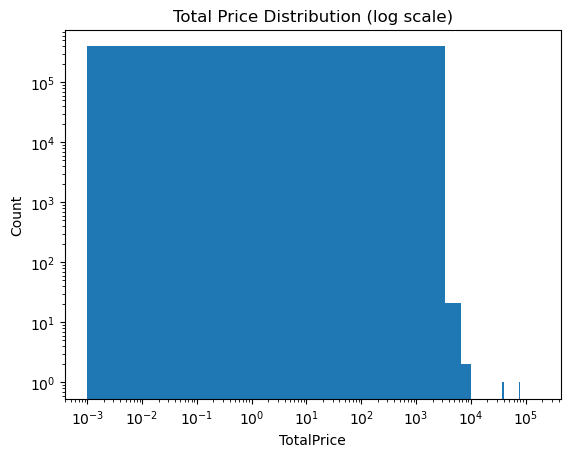

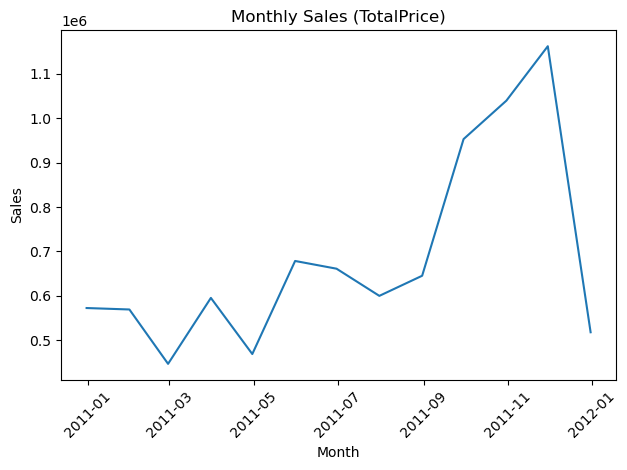

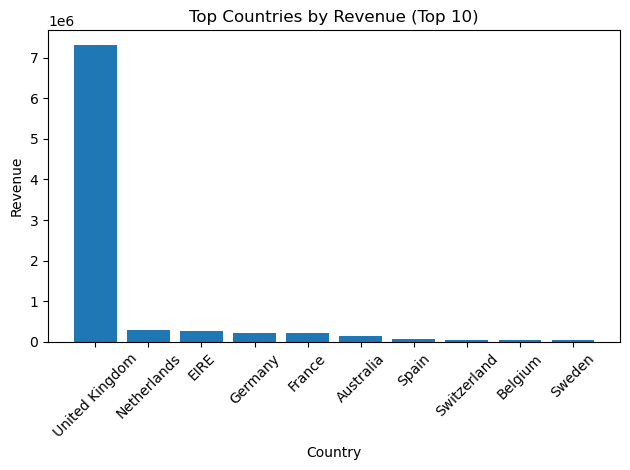

In [18]:
# Show data distribution
# Histograms 
plt.figure()
plt.hist(df_clean['Quantity'], bins=50, log=True)
plt.xscale('log')
plt.title('Quantity Distribution (log scale)')
plt.xlabel('Quantity')
plt.ylabel('Count')
plt.show()

plt.figure()
plt.hist(df_clean['UnitPrice'], bins=50, log=True)
plt.xscale('log')
plt.title('Unit Price Distribution (log scale)')
plt.xlabel('UnitPrice')
plt.ylabel('Count')
plt.show()

plt.figure()
plt.hist(df_clean['TotalPrice'], bins=50, log=True)
plt.xscale('log')
plt.title('Total Price Distribution (log scale)')
plt.xlabel('TotalPrice')
plt.ylabel('Count')
plt.show()

# Monthly sales trend
monthly = df_clean.set_index('InvoiceDate').resample('ME')['TotalPrice'].sum()
plt.figure()
plt.plot(monthly.index, monthly.values)
plt.title('Monthly Sales (TotalPrice)')
plt.xlabel('Month'); plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top countries by revenue 
country_rev = df_clean.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure()
plt.bar(country_rev.index, country_rev.values)
plt.title('Top Countries by Revenue (Top 10)')
plt.xlabel('Country'); plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Insights Data Distribution
- The Quantity, UnitPrice and Total Price data are highly right-skewed, meaning most transactions involve small quantities and low unit prices, but a few records have extremely large values (outliers).
- We use log-scale for the x-axis to show the highly skewed data. 
- A line chart showing monthly total sales, with a steady increase toward the end of 2011 and a sharp drop in December. The sharp drop in December likely happens because the dataset cuts off mid-month (common in the Online Retail dataset).
- The dataset is heavily UK-centric, with most transactions occurring there.

### Feature Engineering: Recency, Frequency and Monetary (RFM)  
RFM features are widely used in marketing and customer analytics to segment customers based on how recently, how often, and how much they buy. They are a common baseline in customer segmentation and churn prediction tasks.  
By aggregating into RFM features per customer, you get a compact, meaningful representation of behavior:
- Recency: days since last pruchase
- Frequency: number of invoices
- Monetary: total amount  

RFM shape (first 5 rows): (4338, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


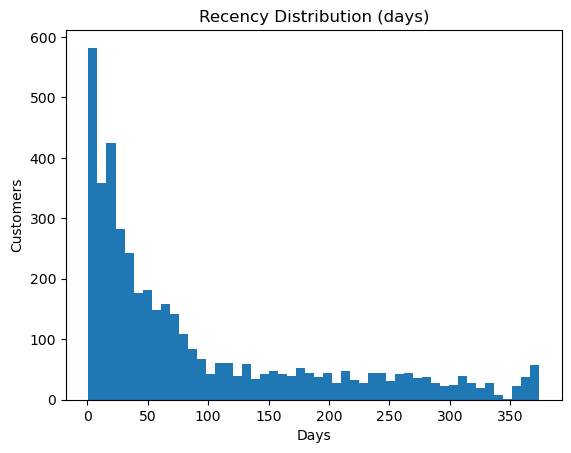

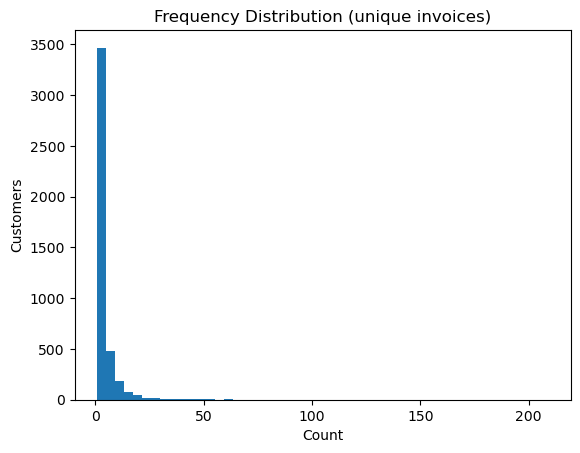

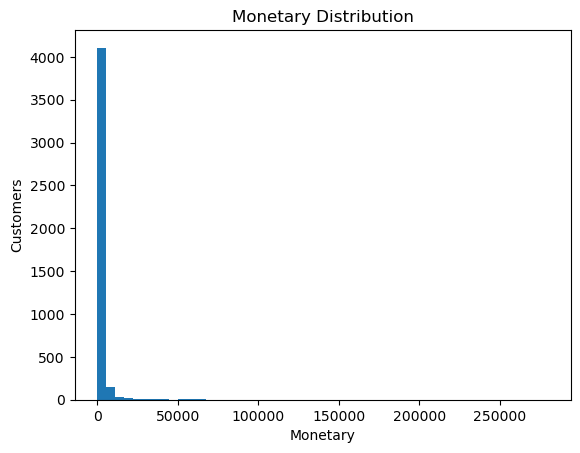


RFM correlations:
            Recency  Frequency  Monetary
Recency    1.000000  -0.260578 -0.122097
Frequency -0.260578   1.000000  0.553650
Monetary  -0.122097   0.553650  1.000000


In [21]:
# Feature engineering
ref_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPrice':'Monetary'}).reset_index()

print("RFM shape (first 5 rows):", rfm.shape)
display(rfm.head())

# RFM Distributions
plt.figure()
plt.hist(rfm['Recency'], bins=50)
plt.title('Recency Distribution (days)')
plt.xlabel('Days'); plt.ylabel('Customers')
plt.show()

plt.figure()
plt.hist(rfm['Frequency'], bins=50)
plt.title('Frequency Distribution (unique invoices)')
plt.xlabel('Count'); plt.ylabel('Customers')
plt.show()

plt.figure()
plt.hist(rfm['Monetary'], bins=50)
plt.title('Monetary Distribution')
plt.xlabel('Monetary'); plt.ylabel('Customers')
plt.show()

# RFM Correlation Matrix
print("\nRFM correlations:")
print(rfm[['Recency','Frequency','Monetary']].corr())

#### Insights RFM Features  
All RFM features are right skewed.
- Recency:
  Most active customers buy recently. 
- Frequency:
  Most customers made only one or two purchases.
  A small number made many repeat purchases (outliers with Frequency > 50).
- Monetary:
  Most customers fall in a moderate spending range, with fewer extremely high spenders.

#### Conclusion
To reduce skewness and ensure balanced feature scaling for clustering, a log transformation will be applied to all RFM features (before clustering).

#### Insights RFM Correlation Matrix
- Moderate positive correlation between Frequency and Monetary. This is expected — loyal customers spend more.

## Instructions: Step 4
"Perform Analysis Using Unsupervised Learning Models of your Choice, Present Discussion, and Conclusions.  
Model building and training may depend on their data type(s) and task type(s). Depending on your project, you may have one model or more. Generally, it is deemed a higher quality project if you compare multiple models and show your understanding of why specific models work better than the other or what limitations or cautions specific models may have. When using multiple models, at least one of them should be an unsupervised approach. 
For machine learning models, another recommendation is to show enough effort on the hyperparameter optimization."

### Plan
- Create a K-Means Clustering Model.
- The best K will be determined by using the maximum silhouette score.
- Show dimensionality reduction done by PCA and NMF.
- Check the K-Means clusters with a Random Forest CLassifier (supervised model).

### Pre-processing and scaling
- We use log transform for RFM features
- For PCA and K-Means: we use standardization to zero mean.
- For NMF: we use MinMAx scaling to get only non-negative data.

In [28]:
# Log transform 
X = rfm[['Recency','Frequency','Monetary']].copy()
X[['Recency','Frequency','Monetary']] = np.log1p(X[['Recency','Frequency','Monetary']])

# Scale
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# For NMF (non-negative), use MinMax scaling after log
mm = MinMaxScaler()
X_mm = mm.fit_transform(X)

### Dimensionality reduction and visualization with PCA
- We use PCA to visualize customers in 2D.
- PCs are used only for visualization (not for clustering).
- We inspect the explained variance.

Explained variance by each component: [0.751  0.1876]
Cumulative explained variance: 0.9386

PCA Component Loadings:


,PC1,PC2
Recency,-0.512,0.850
Frequency,0.618,0.262
Monetary,0.597,0.457



Correlation between PCs and original features:


,Recency,Frequency,Monetary
PC1,-0.769,0.927,0.896
PC2,0.637,0.197,0.343


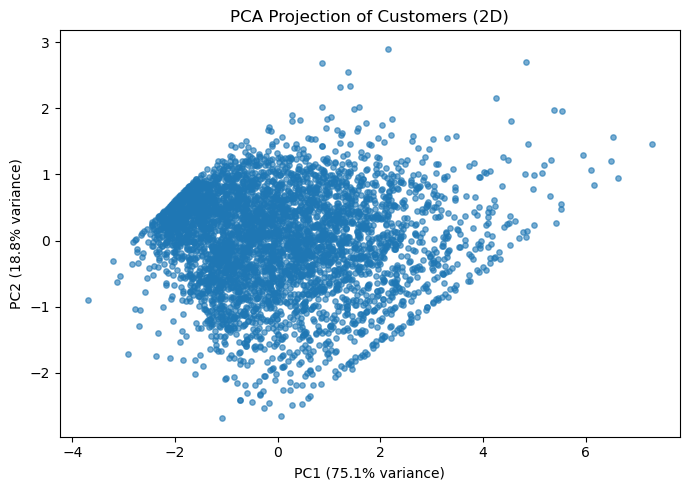

In [30]:
# PCA on standardized RFM data 
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_std)

# Explained variance
explained_var = pca.explained_variance_ratio_
cum_var = np.sum(explained_var)

print("Explained variance by each component:", explained_var.round(4))
print("Cumulative explained variance:", round(cum_var, 4))

# Component loadings (feature contributions)
loadings = pd.DataFrame(
    pca.components_.T,
    index=['Recency', 'Frequency', 'Monetary'],
    columns=['PC1', 'PC2']
)
print("\nPCA Component Loadings:")
display(loadings.round(3))

# Correlations between original features and Components 
pc_scores = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
corr = pd.concat([pc_scores, pd.DataFrame(X_std, columns=['Recency','Frequency','Monetary'])], axis=1) \
          .corr().loc[['PC1','PC2'], ['Recency','Frequency','Monetary']]
print("\nCorrelation between PCs and original features:")
display(corr.round(3))

# Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=15, alpha=0.6)
plt.title('PCA Projection of Customers (2D)')
plt.xlabel(f'PC1 ({explained_var[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({explained_var[1]*100:.1f}% variance)')
plt.tight_layout()
plt.show()

#### Variance:
- Explained variance: PC1 explains 75.1% of the total variance in RFM data, and PC2 explains 18.76%.
- Cumulative explained variance (0.9386): Together, the first two PCs capture about 93.86% of the total variability — meaning most of the information in the 3D data is preserved in this 2D projection.

#### Insights:
This PCA projection effectively summarizes customer purchase behavior in two dimensions while maintaining most of the original information.
- PC1 has strong positive loadings for Frequency (0.618) and Monetary (0.597) and a negative loading for Recency (-0.512). This means PC1 represents an overall customer value axis — distinguishing loyal, high-spending, and recent customers (high PC1) from inactive or low-value customers (low PC1).
- PC2 loads mainly on Recency (0.850), with smaller contributions from Frequency and Monetary. It likely reflects customer activity recency, separating those who purchased recently from those who have not engaged for a longer time.
- The 2D scatter shows that most customers cluster tightly together, suggesting similar purchasing behavior, while a few points spread outward along PC1 — representing high-value or frequent buyers.

### K-Means Clustering Model

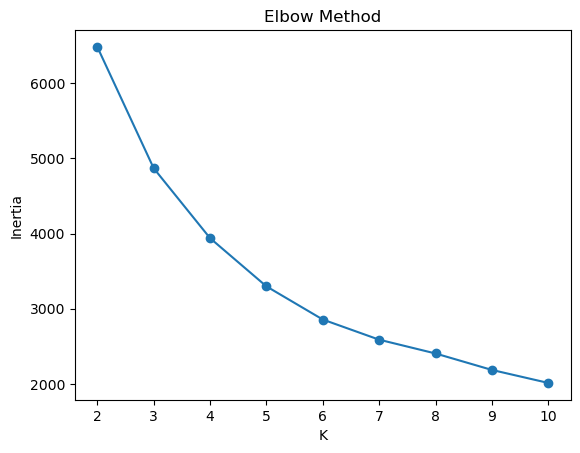

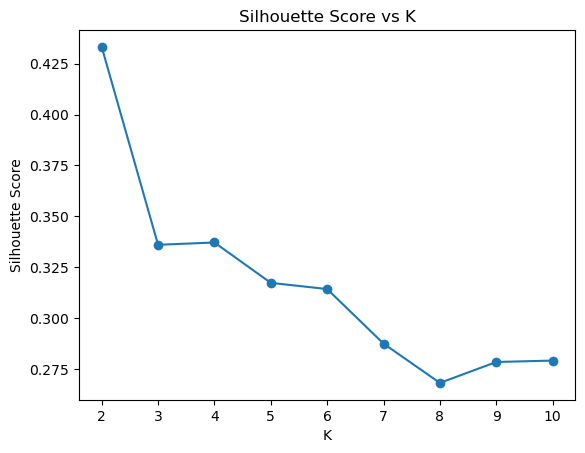

Selected K (by max silhouette): 2


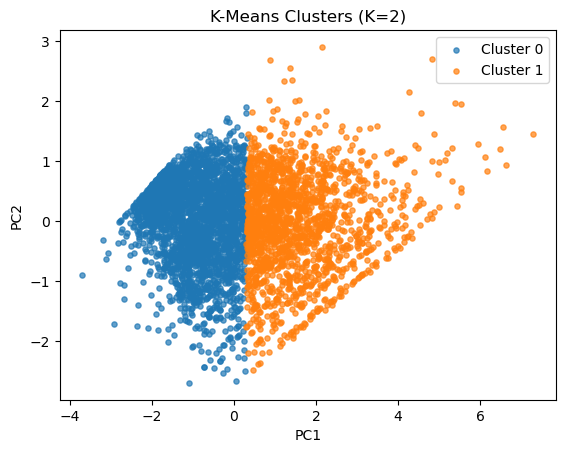

,Recency,Frequency,Monetary
Cluster,,,
0,133.89,1.68,499.77
1,25.70,8.47,4566.96


In [34]:
# Clustering
inertias = []
sil_scores = []
K_vals = range(2, 11)

for k in K_vals:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    labels = km.fit_predict(X_std)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_std, labels)
    sil_scores.append(sil)

plt.figure()
plt.plot(list(K_vals), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('K'); plt.ylabel('Inertia')
plt.xticks(list(K_vals))
plt.show()

plt.figure()
plt.plot(list(K_vals), sil_scores, marker='o')
plt.title('Silhouette Score vs K')
plt.xlabel('K'); plt.ylabel('Silhouette Score')
plt.xticks(list(K_vals))
plt.show()

best_k = K_vals[int(np.argmax(sil_scores))]
print(f"Selected K (by max silhouette): {best_k}")

kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init='auto')
labels = kmeans.fit_predict(X_std)
rfm['Cluster'] = labels

# Visualize
plt.figure()
for c in sorted(rfm['Cluster'].unique()):
    idx = rfm['Cluster'] == c
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=14, alpha=0.7, label=f'Cluster {c}')
plt.title(f'K-Means Clusters (K={best_k})')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend()
plt.show()

# Cluster profiles
cluster_profile = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().round(2)
display(cluster_profile)

#### Cluster Insights
Both the Elbow and Silhouette methods were applied to determine the optimal number of clusters.  
The Elbow curve suggested a potential bend around K=5, indicating diminishing returns in within-cluster variance reduction beyond that point.  
However, the Silhouette score peaked at K=2, suggesting that two clusters are the most well-separated and internally consistent.  

Given this, K=2 was selected as the optimal solution for further analysis, representing a clear division between low-value and high-value customer segments.  
While more clusters might capture finer behavioral nuances (as indicated by the Elbow method), they introduce overlap and reduce interpretability.

### Non-negative matrix factorization (NMF)
- After K-Means NMF is used to gain deeper interpretability — it explains the customers underlying behavioral structure.
- NMF finds latent components — underlying continuous patterns in the data.
- Each customer is represented as a combination of several latent factors.

NMF reconstruction error: 0.0799758297702607

NMF Components (rows = components, cols = [Recency, Frequency, Monetary]):
[[10.1002  0.      0.1532]
 [ 0.      3.824   3.3482]
 [ 0.0341  0.      4.3701]]


,Recency,Frequency,Monetary
Recency-heavy,10.100,0.000,0.153
Frequency-heavy,0.000,3.824,3.348
Monetary-heavy,0.034,0.000,4.370


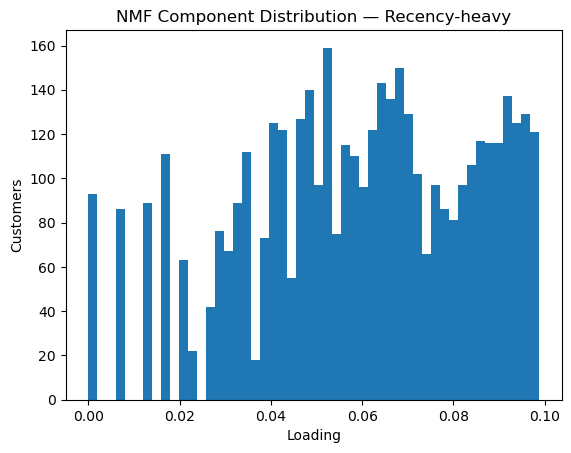

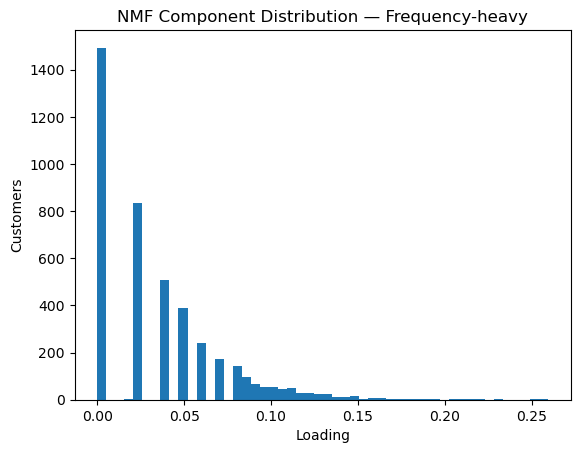

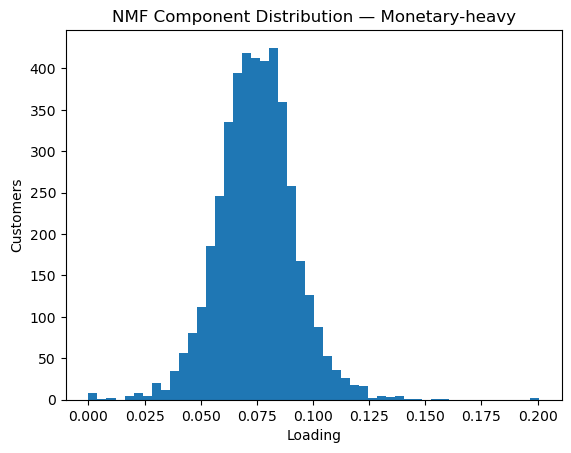

Customer distribution by dominant NMF component:



,Component,Customers,Proportion (%)
0,Monetary-heavy,2404,55.4
1,Recency-heavy,1165,26.9
2,Frequency-heavy,769,17.7


In [37]:
### NMF
n_components = 3
nmf = NMF(n_components=n_components, random_state=RANDOM_STATE, init='nndsvda', max_iter=1000)
W = nmf.fit_transform(X_mm)
H = nmf.components_

print("NMF reconstruction error:", nmf.reconstruction_err_)
print("\nNMF Components (rows = components, cols = [Recency, Frequency, Monetary]):")
print(np.round(H, 4))

# Component names
feature_names = ['Recency', 'Frequency', 'Monetary']
comp_names = [f"{feature_names[i]}-heavy" for i in H.argmax(axis=1)]

# Weight table 
H_df = pd.DataFrame(H, columns=feature_names, index=comp_names).round(3)
display(H_df)

# Loadings per customer
W_df = pd.DataFrame(W, columns=comp_names)
W_df['Cluster'] = labels

# Each customer's dominant component
W_df['TopComp'] = W_df[comp_names].idxmax(axis=1)

# Visualize
for cname in comp_names:
    plt.figure()
    plt.hist(W_df[cname], bins=50)
    plt.title(f'NMF Component Distribution — {cname}')
    plt.xlabel('Loading'); plt.ylabel('Customers')
    plt.show()# NMF
    plt.show()

# Show customer distribution 
comp_counts = W_df['TopComp'].value_counts().rename_axis('Component').reset_index(name='Customers')
comp_counts['Proportion (%)'] = (comp_counts['Customers'] / len(W_df) * 100).round(1)
print("Customer distribution by dominant NMF component:\n")
display(comp_counts)

#### Dimensions  
The NMF model extracts three latent dimensions (components) from the RFM data.
Each component captures a different underlying behavioral pattern in customer purchasing activity.

#### Insights  
- Component 1 / Recency heavy: captures inactive or long-dormant customers (higher days since last purchase).
- Component 2 / Frequence heavy: reflects purchase frequency — customers with repeated interactions.
- Component 3 / Monetary heavy: corresponds to Monetary value, highlighting high-spending customers.

#### Distribution  
The component loadings show most customers have low to moderate scores, with a few having strong loadings on individual components — indicating diverse but concentrated behavioral groups.

#### Marketing Insights  
- Customers with high Frequency-heavy and Monetary-heavy scores are loyal and profitable — ideal for retention and upsell campaigns.
- Recency-heavy customers (inactive or long-unengaged) represent a win-back opportunity through reactivation offers or reminders.
- Customers with low loadings across all components may reflect irregular or low-value shoppers, suitable for targeted awareness or acquisition campaigns.

#### Summary
NMF effectively decomposed the RFM data into three interpretable behavioral dimensions, achieving a low reconstruction error (about 0.08).
This confirms that NMF captures key customer behavior patterns while preserving data structure, supporting more targeted marketing strategies.

### Random Forest validation of K-Means clusters (including Hyperparameter Tuning with GridSearchCV)

Untuned Accuracy: 0.9885

Best CV Accuracy: 0.9881
Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

Test Accuracy: 0.9885

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       804
           1       0.98      0.99      0.98       498

    accuracy                           0.99      1302
   macro avg       0.99      0.99      0.99      1302
weighted avg       0.99      0.99      0.99      1302



<Figure size 640x480 with 0 Axes>

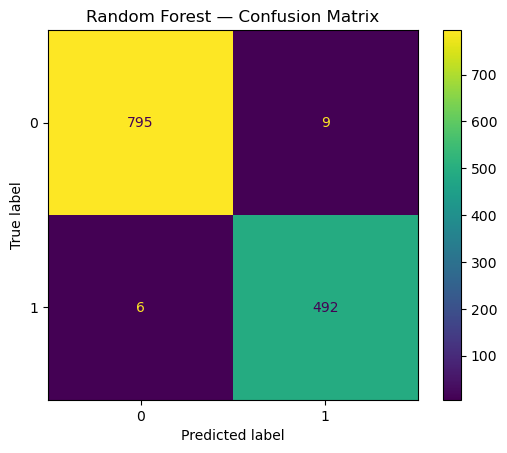

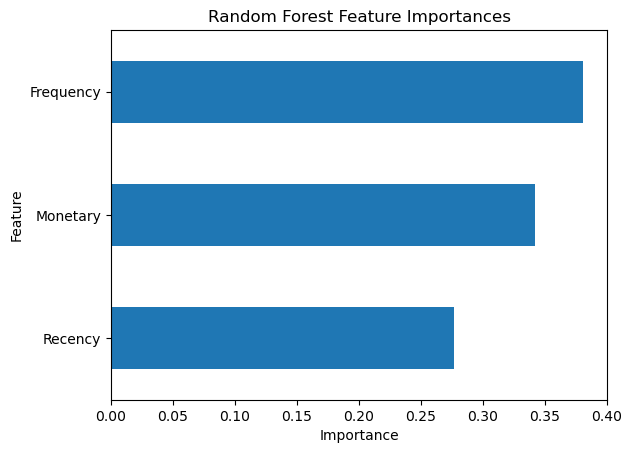

Frequency    0.381215
Monetary     0.341944
Recency      0.276841
dtype: float64

In [40]:
# Features
X = rfm[['Recency','Frequency','Monetary']].copy()
y = rfm['Cluster'].astype(int)

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y)

# Baseline model 
rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)
print("Untuned Accuracy:", round(accuracy_score(y_test, y_pred_base), 4))

# Hyperparameter tuning (GridSearchCV) 
param_grid = {
    "n_estimators": [100, 200, 400, 800, 1600],
    "max_depth": [None, 6, 10, 16],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

gs = GridSearchCV(
    rf, param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=0
)
gs.fit(X_train, y_train)

print("\nBest CV Accuracy:", round(gs.best_score_, 4))
print("Best Params:", gs.best_params_)

# Test-set evaluation
best_rf = gs.best_estimator_
y_pred = best_rf.predict(X_test)

print("\nTest Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=np.sort(y.unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.sort(y.unique()))
plt.figure()
disp.plot(values_format='d')
plt.title("Random Forest — Confusion Matrix")
plt.show()

# Feature importance 
importances = pd.Series(best_rf.feature_importances_, index=['Recency','Frequency','Monetary']).sort_values(ascending=True)
plt.figure()
importances.plot(kind='barh')
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
importances.sort_values(ascending=False)

#### Conclusion:
- This is the supervised validation of how separable and interpretable our unsupervised clusters really are.
- The classifier achieved an excellent accuracy of 98.85%, with precision, recall, and F1-scores all above 0.98 — confirming strong model reliability.
- The K-Means clusters are highly separable in RFM space — Random Forest can almost perfectly classify customers into their cluster based on Recency, Frequency, and Monetary.
- Frequency contributes the most to the model’s predictive power, followed by Monetary and Recency, confirming that customer engagement frequency is the strongest behavioral signal.
- Overall: The Random Forest serves as a supervised validation step demonstrating that the clustering results are meaningful and stable..

#### Marketing Insights:
- Frequency dominates cluster differentiation — suggesting that customer engagement (repeat purchases) is the main driver of segmentation.
- High-frequency, high-monetary customers represent a core loyal base — ideal for retention and loyalty programs.
- Low-frequency, low-monetary customers are at risk of churn — potential targets for reactivation or promotional offers.
- Recency’s moderate importance implies that while recent activity matters, consistent purchasing behavior is more valuable in defining long-term customer value.

### Conclusions and Discussion

#### Conclusions:
- The project successfully applied unsupervised learning (K-Means, PCA, NMF) to uncover meaningful customer segments using RFM features.
- K-Means clustering revealed two distinct behavioral groups, separating customers based on purchasing frequency and spending patterns.
- PCA helped visualize variance and confirmed separation between clusters, while NMF provided greater interpretability by identifying latent behavioral dimensions.
- A Random Forest classifier was then used for supervised validation, confirming that the clusters are highly separable with 98.85% accuracy. This demonstrates strong cluster stability and real-world predictability.
- Frequency emerged as the most influential feature in defining customer segments, followed by Monetary and Recency, aligning with typical behavioral marketing principles.
- Overall: The integration of unsupervised and supervised methods shows how clustering can generate actionable insights, and how supervised learning can validate and explain the robustness of those insights.

#### Discussion:
- The analysis relied solely on RFM features; incorporating additional variables such as product categories, customer demographics, or geography could further enrich segmentation quality.
- While the current model offers interpretable clusters, advanced interpretability tools (e.g., SHAP, decision tree visualization) could enhance understanding of feature interactions.

## Instructions: Step 5
"Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, Video presentation, and GitHub Repository."

#### Deliverables:
- Jupyter Notebook
- Video presentation
- GitHub Repository

## Citation
- http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx  
- https://archive.ics.uci.edu/dataset/352/online+retail
- The RFM analysis page on Wikipedia — a concise overview of the concept: https://en.wikipedia.org/wiki/RFM_(market_research)
- Coursera: Peer-graded Assignment: CSCA 5632 Unsupervised Algorithms in Machine Learning Final Project

## AI Acknowledgement
ChatGPT-5 (OpenAI, 2025) was used to assist in proofreading and improving the grammatical accuracy of the Markdown content. No substantive changes to the original ideas or analysis were made by the model.